# Text as Data project 3: Language Modelling

In this week's project,  explore basic techniques for language modelling.

The aims of this project are:
*   Model the probability of generating language
*   Evaluating the quality of language model using perplexity
*   Understand and address issues of sparsity in language modelling
*   Learn applications of language models in understanding text

**Before you start, save a copy of this project to your drive using "File > Save a Copy in Drive".** If you skip this step, you may lose progress that you have made (e.g., if you close the browser tab or your computer crashes).

**Note:** Colab may hide some of this project by collapsing a section. You'd see something that says "X cells hidden" (like below). Click on it to expand that section of the project.

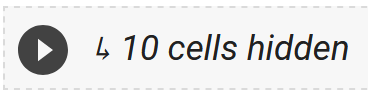

## Setting up the labtest function

As with previous projects,  use a `labtest` function so that you can check your code. You need to install and load it with the code below.

In [ ]:
# Installs the labtest system and loads the tests for this specific project

!pip install -U git+https://github.com/jakelever/glasgowcs_labtest.git
from glasgowcs_labtest.textasdata.lab3 import labtest

  Cloning https://github.com/jakelever/glasgowcs_labtest.git to /tmp/pip-req-build-mbnx1k5f
  Running command git clone --filter=blob:none --quiet https://github.com/jakelever/glasgowcs_labtest.git /tmp/pip-req-build-mbnx1k5f
  Resolved https://github.com/jakelever/glasgowcs_labtest.git to commit 38b7b69854e507a4609e0fd1a6d933bff4542063
  Preparing metadata (setup.py) ... done
  Created wheel for glasgowcs_labtest: filename=glasgowcs_labtest-1.1.6-py3-none-any.whl size=30007 sha256=a068acfb24da9c2ec7d269e888b4fe5ed2721b13fd8e6cd80b0398daac207ab5
  Stored in directory: /tmp/pip-ephem-wheel-cache-bnkhts_7/wheels/d8/27/59/a0aa2eb4007eb0f2ca7228c1eb406ba1d7fbfd5412b56452af
Successfully built glasgowcs_labtest


## Loading the Reddit data

 be using the same Reddit data from the previous projects. I will download it and tokenize it with [spaCy](https://spacy.io/) for later use.

**This time, I are going to tokenize it a little differently.**

First, let's download it:

In [ ]:
!wget -O reddit_posts.json https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EY_R8Y7DkrxMqXGe-zlgeNkBdJU5ZNTf8FYrN2pqDwddMA?download=1

--2025-01-31 17:04:45--  https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EY_R8Y7DkrxMqXGe-zlgeNkBdJU5ZNTf8FYrN2pqDwddMA?download=1
Resolving gla-my.sharepoint.com (gla-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to gla-my.sharepoint.com (gla-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=8ef1d18f92c34cbca9719efb396078d9 [following]
--2025-01-31 17:04:46--  https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=8ef1d18f92c34cbca9719efb396078d9
Reusing existing connection to gla-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1279064 (1.2M) [application/json]
Saving to: ‘reddit_posts.json’

reddit_posts.json   100%[===================>]   1.22M  1.88MB/s    in 0.6s    

2025-01-31 17:04:47 (1

Let's load in the posts:

In [ ]:
import json

with open('reddit_posts.json') as f:
    posts = json.load(f)

len(posts)

2000

A reminder of what a post looks like:

In [ ]:
posts[0]

{'subreddit': 'Soda',
 'title': 'Anyone tried Irn Bru?',
 'score': 8,
 'id': 'ou5yp1',
 'author': 'jackibhoy',
 'body': 'It’s a Scottish drink and it’s banned some countries and I was wondering if anyone here has tried it. It has quite a unique taste and it’s not something you’d forget quickly. You either love it or hate it I think.'}

### Alternative parsing

 going to do a few things differently this time.

1.  going to use a slimmed down version of spaCy. This is to show that you can turn off bits of spaCy and make it **a lot** faster.
2.  going to keep stopwords this time
3.  not going to lemmatize, but I will still use the lowercase version of the token text

I want to split the text into its tokens and not do anything special to them.

Let's load in a slimmed down version of spaCy with a few things (e.g. tagger, parser, NER) turned off.

In [ ]:
import spacy

# Load the small english model.
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
nlp.remove_pipe('lemmatizer')

('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7bf2b7028390>)

And  define a modified version of the spaCy pipeline function from previous projects that doesn't throw away stopwords and gives the original text, not lemmas.

In [ ]:
def text_pipeline_spacy_special(text):
  tokens = []
  doc = nlp(text)
  for t in doc:
    if not t.is_punct and not t.is_space: # what I removed: "not t.is_stop and"
      tokens.append(t.text.lower()) # what I changed: t.text instead of t.lemma_
  return tokens

Now if I tokenize everything, it is much faster.

In [ ]:
from tqdm import tqdm # This provides a nice progress bar

for post in tqdm(posts):
    post['tokens'] = text_pipeline_spacy_special(post['title'] + '\n' + post['body'])

100%|██████████| 2000/2000 [00:22<00:00, 90.68it/s]


### Flattening the tokens

For this project, I want to deal with the whole collection of posts as a single long list of tokens.  make one list and combine each post with a special token `<START>` at the beginning of each.

In [ ]:
posts_flattened_tokens = []
for post in posts:
  posts_flattened_tokens += ['<START>'] + post['tokens']
len(posts_flattened_tokens)

189428

That's quite a few tokens!

And again,  make a little mini corpus of sentences and create the same flattened list of tokens with the `<START>` special token before each sentence. This will be useful for a few places later.

In [ ]:
mini_sentences = [
    "My favourite soft drink is Apple Tango, but I also love Irn Bru.",
    "Irn Bru is a great drink.",
    "I once found a can of Irn Bru in St Petersburg.",
    "Irn Bru is a soft drink launched in 1901 by AG Barr.",
    "IRN-BRU is made at AG Barr in Cumbernauld."
]

mini_flattened = []
for x in mini_sentences:
  mini_flattened += ['<START>'] + text_pipeline_spacy_special(x)

print(mini_flattened)

['<START>', 'my', 'favourite', 'soft', 'drink', 'is', 'apple', 'tango', 'but', 'i', 'also', 'love', 'irn', 'bru', '<START>', 'irn', 'bru', 'is', 'a', 'great', 'drink', '<START>', 'i', 'once', 'found', 'a', 'can', 'of', 'irn', 'bru', 'in', 'st', 'petersburg', '<START>', 'irn', 'bru', 'is', 'a', 'soft', 'drink', 'launched', 'in', '1901', 'by', 'ag', 'barr', '<START>', 'irn', 'bru', 'is', 'made', 'at', 'ag', 'barr', 'in', 'cumbernauld']


## Unigram language model

 going to start with a unigram language model. This will provide the probability of each token occurring and has lots of uses.

Recall that a unigram model treats each token independently and does not take any context (i.e. the previous tokens) into account.

Before I calculate the unigram probabilities, I need to calculate the unigram counts.  use the [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) class again.

In [ ]:
from collections import Counter
posts_unigram_counts = Counter(posts_flattened_tokens)
posts_unigram_N = len(posts_flattened_tokens) # also the same as sum(posts_unigram_counts.values())

I can get the number of times that 'irn' appears in the posts:

In [ ]:
posts_unigram_counts['irn']

10

Now time to calculate unigram probabilities:

**Exercise:** Write a function `unigram_token_prob` that given a token, the unigram counts and the total number of unigrams, returns the probability of that token


In [ ]:
# ANSWER
def unigram_token_prob(next_token, unigram_counts, unigram_N):
  return unigram_counts[next_token] / unigram_N

unigram_token_prob('irn', posts_unigram_counts, posts_unigram_N)

5.279050615537302e-05

Check that your function returns a probability of zero for a new unseen token.

In [ ]:
unigram_token_prob('totallynotatoken', posts_unigram_counts, posts_unigram_N)

0.0

And now you can run the labtest function:

In [ ]:
labtest(unigram_token_prob)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ('cup', {'cup': 2, 'spoon': 2, 'glass': 6, 'fork': 1}, 11). Running... 
Output: 0.18182
OK.

Input: ('plate', {'plate': 2, 'cup': 2, 'fork': 5, 'spoon': 5}, 14). Running... 
Output: 0.14286
OK.

Input: ('fork', {'bowl': 4, 'fork': 5, 'plate': 3, 'cup': 1}, 13). Running... 
Output: 0.38462
OK.

Input: ('cup', {'plate': 2, 'glass': 3, 'fork': 1, 'cup': 1}, 7). Running... 
Output: 0.14286
OK.

Input: ('glass', {'glass': 5, 'spoon': 3}, 8). Running... 
Output: 0.625
OK.

----------------------------
5 testcases PASSED
----------------------------


Now I can use the individual token probabilities to calculate the probability of a whole sequence. Remember that the unigram probability of a sequence treats each token independently:

$$ P(w_1, ... w_N) = \prod_{i=1}^N \hat{p}(w_i) $$

**Exercise:** Write a function `unigram_sequence_prob` that given a sequence of tokens (and the unigram data), calculates the probability of the sequence.

Remember that if a sequence contains a token that doesn't exist in the corpus, the probability of the sequence should be zero.

In [ ]:
# ANSWER

def unigram_sequence_prob(sequence, unigram_counts, unigram_N):
  prob = 1
  for t in sequence:
    prob *= unigram_token_prob(t, unigram_counts, unigram_N)

  return prob

unigram_sequence_prob(['i', 'like', 'irn', 'bru'], posts_unigram_counts, posts_unigram_N)

5.810905251121602e-13

In [ ]:
labtest(unigram_sequence_prob)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['glass', 'glass', 'glass', 'cup', 'cup'], {'cup': 2, 'spoon': 2, 'glass': 6, 'fork': 1}, 11). Running... 
Output: 0.00536
OK.

Input: (['spoon', 'spoon', 'fork'], {'fork': 1, 'spoon': 5}, 6). Running... 
Output: 0.11574
OK.

Input: (['fork', 'fork', 'cup', 'fork'], {'fork': 2, 'glass': 6, 'cup': 4}, 12). Running... 
Output: 0.00154
OK.

Input: (['glass', 'cup', 'fork', 'cup', 'cup'], {'cup': 5, 'glass': 3, 'fork': 1}, 9). Running... 
Output: 0.00635
OK.

Input: (['spoon', 'spoon', 'spoon', 'glass'], {'fork': 1, 'glass': 1, 'bowl': 6, 'spoon': 2}, 10). Running... 
Output: 0.0008
OK.

----------------------------
5 testcases PASSED
----------------------------


For long sequences, I start multiplying by very small numbers. This is a very bad idea computationally. Computers only have a limited number of bits for a number and precision problems start happening when multiplying by lots of small numbers.

A better idea is to do everything with logarithms.  work with log base 2 here. The above equation becomes:

$$ LogP(w_1, ... w_N) = \sum_{i=1}^N \log_2 \hat{p}(w_i) $$

**Exercise:** Write a function `unigram_sequence_logprob` which is equivalent to the `unigram_sequence_prob` method but using log2 and summation as in the equation above.

In [ ]:
# ANSWER

import math

def unigram_sequence_logprob(sequence, unigram_counts, unigram_N):
  logprob = 0
  for t in sequence:
    logprob += math.log2(unigram_token_prob(t, unigram_counts, unigram_N))

  return logprob

unigram_sequence_logprob(['i', 'like', 'irn', 'bru'], posts_unigram_counts, posts_unigram_N)

-40.64630230233775

I can sanity check that it's working by taking the log2 of the original function and seeing if I get the same result.

In [ ]:
math.log2(unigram_sequence_prob(['i', 'like', 'irn', 'bru'], posts_unigram_counts, posts_unigram_N))

-40.64630230233775

In [ ]:
labtest(unigram_sequence_logprob)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['glass', 'glass', 'glass', 'cup', 'cup'], {'cup': 2, 'spoon': 2, 'glass': 6, 'fork': 1}, 11). Running... 
Output: -7.54227
OK.

Input: (['spoon', 'spoon', 'fork'], {'fork': 1, 'spoon': 5}, 6). Running... 
Output: -3.11103
OK.

Input: (['fork', 'fork', 'cup', 'fork'], {'fork': 2, 'glass': 6, 'cup': 4}, 12). Running... 
Output: -9.33985
OK.

Input: (['glass', 'cup', 'fork', 'cup', 'cup'], {'cup': 5, 'glass': 3, 'fork': 1}, 9). Running... 
Output: -7.29888
OK.

Input: (['spoon', 'spoon', 'spoon', 'glass'], {'fork': 1, 'glass': 1, 'bowl': 6, 'spoon': 2}, 10). Running... 
Output: -10.28771
OK.

----------------------------
5 testcases PASSED
----------------------------


Let's try computing the unigram probabilities of a few tokens.

In [ ]:
for token in ['the','game','defenenstrate']:
  print("Pr(",token,"):", unigram_token_prob(token, posts_unigram_counts, posts_unigram_N))

Pr( the ): 0.0327195557151002
Pr( game ): 0.0038114745444179318
Pr( defenenstrate ): 0.0


The probabilities should be about 3% for 'the', 0.4% for 'game' and 0 for 'defenestrate'.

Now, try computing the probability of a sequence of tokens.  

In [ ]:
probability = unigram_sequence_prob(["the", "end", "of", "the", "world", "as", "I", "know", "it"], posts_unigram_counts, posts_unigram_N)
print('{:.40f}'.format(probability))

0.0000000000000000000010693914958728715991


This is already a very small number and most of the values in these sequence are large by typical probability values. This is the reason that I usually do the probability computation in log space in practice to avoid problems of underflow.

## Application: Spelling correction

I can use this simple language model to build a spelling corrector.

This builds on ideas of a [spelling corrector from code by Peter Norvig](http://norvig.com/spell-correct.html), a director of research at Google.

### The objective

For a given misspelled token, I want to find candidate tokens that it could be assuming that the real token is only a few edits away. With those candidate tokens, I will then calculate the most likely with the language model.


### Edit distance


What do I mean by edits? Perhaps, I transposed two letters, accidentally added a letter, or deleted a letter, etc.

I need a function that can generate a list of tokens that are a single edit away. For example 'go' is one edit away from 'lo'.

Here is the `generate_edits1` function.

In [ ]:
def generate_edits1(token):
  "All edits that are one edit away from `token`."
  letters    = 'abcdefghijklmnopqrstuvwxyz'
  splits     = [(token[:i], token[i:])  for i in range(len(token) + 1)]
  deletes    = [L + R[1:]               for L, R in splits if R]
  transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
  replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
  inserts    = [L + c + R               for L, R in splits for c in letters]
  return set(deletes + transposes + replaces + inserts)

print(generate_edits1('irn'))

{'inr', 'irnf', 'imn', 'iyrn', 'irnk', 'iry', 'irfn', 'lirn', 'ibn', 'ibrn', 'irjn', 'irun', 'irt', 'jirn', 'irpn', 'iri', 'irl', 'irln', 'cirn', 'irrn', 'irno', 'irnd', 'hrn', 'oirn', 'irng', 'iru', 'sirn', 'igrn', 'irk', 'trn', 'icn', 'irne', 'irnq', 'qirn', 'nirn', 'inrn', 'wrn', 'irna', 'irns', 'irnc', 'irj', 'girn', 'isn', 'ird', 'in', 'ien', 'itn', 'brn', 'irqn', 'idn', 'iqrn', 'iwrn', 'lrn', 'zrn', 'vrn', 'dirn', 'ira', 'ixrn', 'frn', 'ern', 'irg', 'mrn', 'irnl', 'irdn', 'iern', 'imrn', 'ilrn', 'grn', 'irvn', 'irnw', 'ivn', 'firn', 'ifrn', 'irx', 'iyn', 'ian', 'ipn', 'airn', 'irnr', 'irkn', 'iun', 'idrn', 'iran', 'arn', 'ircn', 'irnb', 'srn', 'iorn', 'irnj', 'irnp', 'irz', 'ikn', 'rn', 'ign', 'ijn', 'zirn', 'icrn', 'irn', 'jrn', 'irnz', 'iro', 'ihrn', 'iirn', 'irnn', 'iren', 'iprn', 'ijrn', 'crn', 'irnh', 'iln', 'irnv', 'iryn', 'irv', 'ivrn', 'hirn', 'orn', 'iron', 'urn', 'iarn', 'itrn', 'irni', 'ion', 'irin', 'irwn', 'rin', 'tirn', 'uirn', 'izrn', 'irzn', 'xirn', 'iurn', 'kirn'

And I may want to get tokens that are two edits away.

In [ ]:
def generate_edits2(token):
  "All edits that are two edits away from `token`."
  return set(e2 for e1 in generate_edits1(token) for e2 in generate_edits1(e1))

print(generate_edits2('irn'))

{'erz', 'irnfm', 'wiarn', 'irjn', 'hoirn', 'ixrnp', 'tirnr', 'iyln', 'irnbw', 'irsyn', 'parn', 'zirne', 'iadrn', 'isfrn', 'exn', 'unirn', 'irnxw', 'grnb', 'ipq', 'ired', 'itng', 'zrs', 'diron', 'fun', 'giru', 'irlny', 'isrvn', 'ccn', 'qron', 'tirf', 'ilnv', 'tirxn', 'irnnq', 'grhn', 'tign', 'frnc', 'irgsn', 'ixrnr', 'mitn', 'irns', 'srun', 'brs', 'irdxn', 'opn', 'oron', 'idurn', 'iqrk', 'dwrn', 'arrn', 'irhnx', 'jirun', 'crzn', 'virnn', 'iuan', 'ifnw', 'tinr', 'iwrn', 'ikzn', 'irnyk', 'qrk', 'ireg', 'iznc', 'irnvc', 'irqns', 'irhc', 'fkrn', 'yirwn', 'tire', 'irtln', 'itrnc', 'urun', 'kcn', 'pibrn', 'hwn', 'nirnw', 'isrsn', 'dnr', 'ibnrn', 'itron', 'wiyrn', 'ihj', 'virt', 'irncz', 'itrwn', 'zisn', 'mrnk', 'qurn', 'ain', 'icwn', 'orqn', 'qen', 'grsn', 'ixrnf', 'ieyn', 'jrnr', 'lirkn', 'fixn', 'irygn', 'irnef', 'iyn', 'uirnw', 'yirnm', 'zixn', 'irkon', 'irenp', 'lsirn', 'uxn', 'icrnb', 'ibno', 'ilrnu', 'pjrn', 'iruwn', 'tiln', 'xiqn', 'igrm', 'imrnl', 'irfwn', 'siin', 'iarnd', 'fcn', 'rwi

### Candidate tokens

The two `generate_edits*` functions produce lots of possible tokens, but I know only a few are actually known tokens. And by known tokens, I mean tokens that I have seen in the Reddit post dataset.

**Exercise:** Using the `generate_edits*` functions above, write a function `get_candidate_tokens` that given a token and the unigram counts, returns a **set** of candidate tokens that are within two edit distance and appear in the corpus.

Specifically the candidate tokens should be:
- Only the input token if it is in the corpus
- All the tokens that are 1 or 2 edits away **and** are in the corpus
- Only the input token if there are no other candidate tokens

**Note:** If the input token is in the corpus, it should only return that token so that I don't try to correct it to something else. And if there are no tokens within two edit distances and appear , it should still return the token so that a spelling corrector is given one option to use.

In [ ]:
# ANSWER

def get_candidate_tokens(token, unigram_counts):
  if token in unigram_counts:
    return {token}

  edits1 = [ e for e in generate_edits1(token) if e in unigram_counts ]
  edits2 = [ e for e in generate_edits2(token) if e in unigram_counts ]

  edits = edits1 + edits2
  if edits:
    return set(edits)

  return {token}

get_candidate_tokens('hellp', {'hello':1,'hi':1,'bye':1,'ahoy':1})

{'hello'}

In [ ]:
labtest(get_candidate_tokens)

----------------------------
LABTEST: Running 6 testcases
----------------------------
Input: ('tey', {'me': 1, 'sun': 3, 'heavy': 1, 'sea': 2, 'her': 1}). Running... 
Output: {'me', 'her', 'sea'}
OK.

Input: ('cofee', {'typical': 2, 'will': 2, 'come': 3, 'codes': 1}). Running... 
Output: {'come', 'codes'}
OK.

Input: ('coffee', {'spent': 3, 'coffee': 1, 'offer': 1, 'coffees': 2, 'color': 2}). Running... 
Output: {'coffee'}
OK.

Input: ('spda', {'pc': 2, 'spin': 1, 'pad': 1}). Running... 
Output: {'spin', 'pad'}
OK.

Input: ('brw', {'arm': 1, 'mystery': 2, 'dew': 3, 'filled': 2}). Running... 
Output: {'arm', 'dew'}
OK.

Input: ('cofee', {}). Running... 
Output: {'cofee'}
OK.

----------------------------
6 testcases PASSED
----------------------------


Let's see what the candidates are for 'brp' using the Reddit data

In [ ]:
get_candidate_tokens('brp', posts_unigram_counts)

{'amp',
 'ap',
 'app',
 'are',
 'arm',
 'art',
 'b',
 'bad',
 'bag',
 'ban',
 'bao',
 'bar',
 'bare',
 'bark',
 'barq',
 'bars',
 'bat',
 'bay',
 'bbc',
 'bc',
 'bd',
 'be',
 'bed',
 'beg',
 'bet',
 'bf',
 'bg',
 'big',
 'bin',
 'bird',
 'bit',
 'biz',
 'bkf',
 'bl',
 'blu',
 'bob',
 'bog',
 'boo',
 'born',
 'bot',
 'box',
 'boy',
 'bpm',
 'br',
 'brew',
 'brim',
 'brit',
 'bros',
 'brow',
 'bru',
 'bs',
 'btw',
 'bud',
 'bug',
 'burn',
 'burr',
 'bury',
 'bus',
 'but',
 'buy',
 'bw',
 'bww',
 'by',
 'cap',
 'cp',
 'crop',
 'cry',
 'cup',
 'dr',
 'drip',
 'drm',
 'drop',
 'drs',
 'dry',
 'earp',
 'edp',
 'era',
 'erh',
 'erm',
 'fp',
 'frc',
 'fro',
 'fry',
 'gr',
 'grd',
 'grip',
 'hop',
 'hr',
 'hrs',
 'ip',
 'ir',
 'irc',
 'irn',
 'isp',
 'jp',
 'lp',
 'map',
 'mbp',
 'mp',
 'mr',
 'ncp',
 'nrs',
 'op',
 'or',
 'ori',
 'p',
 'pb',
 'pbr',
 'pop',
 'pre',
 'pro',
 'pry',
 'psp',
 'pvp',
 'qr',
 'r',
 'rc',
 're',
 'rep',
 'rf',
 'rm',
 'rn',
 'rpg',
 'rt',
 'rx',
 'sip',
 'sp',
 'sup

### Using a language model for ranking candidates

For a given misspelt token, I can now get a list of plausible tokens. I need to rank them to choose the likeliest.

Enter the language model! It can give  the probability of a token, potentially taking the context into account. In the case of the unigram model, it ignores previous tokens but I know that a language model can factor in previous tokens. Let's try with the unigram model first.

**Exercise:** Write a function `unigram_spelling_correct` that given a misspelled token (and unigram information), gets a list of candidate tokens, calculates their unigram probabilities and returns the candidate with the highest likelihood.

You will want to use `get_candidate_tokens` and `unigram_token_prob` from before.

In [ ]:
# ANSWER

def unigram_spelling_correct(token, unigram_counts, unigram_N):
  candidate_tokens = get_candidate_tokens(token, unigram_counts)

  likeliest = max(candidate_tokens, key=lambda t:unigram_token_prob(t, unigram_counts, unigram_N))

  return likeliest

unigram_spelling_correct('gmaig', posts_unigram_counts, posts_unigram_N)

'gaming'

In [ ]:
labtest(unigram_spelling_correct)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ('tey', {'heavy': 1, 'sun': 3, 'her': 1, 'sea': 2, 'me': 1}, 8). Running... 
Output: sea
OK.

Input: ('cofee', {'will': 2, 'codes': 2, 'come': 3, 'typical': 1}, 8). Running... 
Output: come
OK.

Input: ('coffee', {'offer': 3, 'coffee': 1, 'coffees': 1, 'spent': 2, 'color': 2}, 9). Running... 
Output: coffee
OK.

Input: ('spda', {'spin': 2, 'pad': 1, 'pc': 1}, 4). Running... 
Output: spin
OK.

Input: ('brw', {'mystery': 1, 'filled': 2, 'dew': 3, 'arm': 2}, 8). Running... 
Output: dew
OK.

----------------------------
5 testcases PASSED
----------------------------


Excellent, now let's step through how the spelling correction is being done for an example token.

In [ ]:
token = "gmaig"
#token = TRY YOUR WORD

candidates = get_candidate_tokens(token, posts_unigram_counts)
print("Spelling candidates for:", token)
for candidate in candidates:
  p = unigram_token_prob(candidate, posts_unigram_counts, posts_unigram_N)
  print(f"{candidate}\t{p:.7f}")

# The correction takes the token that has the highest probability (occurs most often).
correction = unigram_spelling_correct(token, posts_unigram_counts, posts_unigram_N)
print(f"\nSelected correction: {correction}")

Spelling candidates for: gmaig
gang	0.0000053
grain	0.0000053
gain	0.0000211
email	0.0000686
gtaiv	0.0000106
mail	0.0001214
main	0.0002376
gaming	0.0005015

Selected correction: gaming


Woohoo! I have a very basic reddit spelling corrector.
Try it yourself on other words.

However, as  see it's not perfect.  Let's look at a few sequences below and see what it does to each token.

In [ ]:
strings = ["it is amazon", "http www amazin"]
for s in strings:
  tokens = text_pipeline_spacy_special(s)
  corrections = []
  for t in tokens:
    correction = unigram_spelling_correct(t, posts_unigram_counts, posts_unigram_N)
    corrections.append(correction)
  print(s, corrections)


it is amazon ['it', 'is', 'amazon']
http www amazin ['help', 'was', 'again']


Not so 'amazing'. In both of these cases, I estimated the likelihood of spelling correcting each word on its own,  independently.  This fails in obvious cases where the correct word should be apparent given the sequence.

I can do better by taking two factors into account:

1. Computing the probability of the whole sequence of token (in case there are multiple spelling mistakes)
2. Using token context (bi-grams and trigrams) to improve the token probability estimate

 look at the second idea in the following sections.

## N-Gram Language Models

The unigram model isn't a very good one - it doesn't model any previous context. On the other hand, I can't model _all_ of the preceding tokens, because that history will get prohibitively long and extremely sparse. As a compromise, I make a _Markov assumption_ and limit ourselves to a finite history of $n$ tokens.


### Constructing a bigram model

For now,  build a bigram model, which considers only the preceding token:

$$ P(w_i\ |\ w_{0}, ..., w_{i-1}) \approx P(w_i\ |\ w_{i-1}) $$



I want to calculate the probability of one token following the other using the counts of that bigram $C_{ab}$ and the count of the first token $C_a$.

$$  P_{ab} = P(w_i = b\ |\ w_{i-1} = a) = \frac{C_{ab}}{C_{a}} $$




Before I can generate probabilities from bigrams, I need to know the frequency that bigrams appear in the data.

**Exercise:** Write a function `count_bigrams` that given a flattened list of tokens returns a [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) mapping tuples (pairs of neighbouring tokens) to their count in the tokens.

For example `count_bigrams(['a','b','c'])` should give a Counter with values `{ ('a','b'):1, ('b','c'):1 }`

In [ ]:
# ANSWER

def count_bigrams(flattened):
  bigram_counts = Counter()
  for a,b in zip(flattened, flattened[1:]):
    bigram_counts[(a,b)] += 1
  return bigram_counts

count_bigrams(['<START>','irn','bru','is','great','<START>','i','dislike','irn','bru'])

Counter({('<START>', 'irn'): 1,
         ('irn', 'bru'): 2,
         ('bru', 'is'): 1,
         ('is', 'great'): 1,
         ('great', '<START>'): 1,
         ('<START>', 'i'): 1,
         ('i', 'dislike'): 1,
         ('dislike', 'irn'): 1})

In [ ]:
labtest(count_bigrams)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['accidentally', 'halo', 'halo', 'halo'],). Running... 
Output: {('accidentally', 'halo'): 1, ('halo', 'halo'): 2}
OK.

Input: (['teavana', 'teavana', 'order'],). Running... 
Output: {('teavana', 'teavana'): 1, ('teavana', 'order'): 1}
OK.

Input: (['started', 'enough', 'enough', 'started', 'enough', 'enough'],). Running... 
Output: {('started', 'enough'): 2, ('enough', 'enough'): 2, ('enough', 'started'): 1}
OK.

Input: (['hario', 'hario', 'lead'],). Running... 
Output: {('hario', 'hario'): 1, ('hario', 'lead'): 1}
OK.

Input: (['similar', 'college', 'similar'],). Running... 
Output: {('similar', 'college'): 1, ('college', 'similar'): 1}
OK.

----------------------------
5 testcases PASSED
----------------------------


I can get the bigrams of the mini corpus:

In [ ]:
count_bigrams(mini_flattened)

Counter({('<START>', 'my'): 1,
         ('my', 'favourite'): 1,
         ('favourite', 'soft'): 1,
         ('soft', 'drink'): 2,
         ('drink', 'is'): 1,
         ('is', 'apple'): 1,
         ('apple', 'tango'): 1,
         ('tango', 'but'): 1,
         ('but', 'i'): 1,
         ('i', 'also'): 1,
         ('also', 'love'): 1,
         ('love', 'irn'): 1,
         ('irn', 'bru'): 5,
         ('bru', '<START>'): 1,
         ('<START>', 'irn'): 3,
         ('bru', 'is'): 3,
         ('is', 'a'): 2,
         ('a', 'great'): 1,
         ('great', 'drink'): 1,
         ('drink', '<START>'): 1,
         ('<START>', 'i'): 1,
         ('i', 'once'): 1,
         ('once', 'found'): 1,
         ('found', 'a'): 1,
         ('a', 'can'): 1,
         ('can', 'of'): 1,
         ('of', 'irn'): 1,
         ('bru', 'in'): 1,
         ('in', 'st'): 1,
         ('st', 'petersburg'): 1,
         ('petersburg', '<START>'): 1,
         ('a', 'soft'): 1,
         ('drink', 'launched'): 1,
         ('launc

Let's calculate the bigrams for the Reddit posts. This will be useful!

In [ ]:
posts_bigram_counts = count_bigrams(posts_flattened_tokens)

Now I have a method for bigram counts, I can calculate the probability of a next word, given the previous token:

$$ P(w_i \ |\ w_{i-1} ) $$

Specifically for the probability for token $b$ following token $a$:

$$  P_{ab} = P(w_i = b\ |\ w_{i-1} = a) = \frac{C_{ab}}{C_{a}} $$

where $C_{ab}$ is the bigram count of $(a,b)$ and $C_a$ is the unigram count of $a$.

**Exercise:** Write a function `bigram_token_prob` that takes in the previous token, the next token and the unigram and bigram counts and calculates the conditional probability of the next token given the previous token.

In [ ]:
# ANSWER

def bigram_token_prob(prev_token, next_token, unigram_counts, bigram_counts):
  return bigram_counts[(prev_token,next_token)] / unigram_counts[prev_token]

bigram_token_prob('irn', 'bru', posts_unigram_counts, posts_bigram_counts)

1.0

In [ ]:
labtest(bigram_token_prob)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ('a', 'b', {'a': 8, 'b': 7}, {('a', 'a'): 2, ('a', 'b'): 2, ('b', 'a'): 4, ('b', 'b'): 3}). Running... 
Output: 0.25
OK.

Input: ('b', 'b', {'a': 8, 'b': 9}, {('a', 'a'): 1, ('a', 'b'): 2, ('b', 'a'): 1, ('b', 'b'): 4}). Running... 
Output: 0.44444
OK.

Input: ('a', 'b', {'a': 7, 'b': 6}, {('a', 'a'): 3, ('a', 'b'): 1, ('b', 'a'): 1, ('b', 'b'): 1}). Running... 
Output: 0.14286
OK.

Input: ('a', 'b', {'a': 7, 'b': 6}, {('a', 'a'): 1, ('a', 'b'): 3, ('b', 'a'): 4, ('b', 'b'): 2}). Running... 
Output: 0.42857
OK.

Input: ('a', 'b', {'a': 5, 'b': 5}, {('a', 'a'): 1, ('a', 'b'): 2, ('b', 'a'): 2, ('b', 'b'): 1}). Running... 
Output: 0.4
OK.

----------------------------
5 testcases PASSED
----------------------------


### Using bigrams for spelling correction

 use the bigram model to improve the spelling correction model. This time it will use the prior token to give some context to the probability calculations.

**Exercise:** Write a function `bigram_spelling_correct` that takes in the previous token, the token to be spell-checked, the unigram/bigram counts and uses the bigram probability function (from above) to find the most likely token. Look back at your `unigram_spelling_correct` function.

In [ ]:
# ANSWER

def bigram_spelling_correct(prev_token, token, unigram_counts, bigram_counts):
  candidate_tokens = get_candidate_tokens(token, unigram_counts)

  likeliest = max(candidate_tokens, key=lambda t:bigram_token_prob(prev_token, t, unigram_counts, bigram_counts))

  return likeliest

bigram_spelling_correct('irn', 'burp', posts_unigram_counts, posts_bigram_counts)

'bru'

In [ ]:
labtest(bigram_spelling_correct)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ('i', 'hcacn', Counter({'where': 7, 'i': 6, 'can': 6}), Counter({('i', 'can'): 4, ('where', 'i'): 3})). Running... 
Output: can
OK.

Input: ('the', 'owvnyr', Counter({'the': 9, 'and': 8, 'owner': 5}), Counter({('and', 'the'): 2, ('the', 'owner'): 1})). Running... 
Output: owner
OK.

Input: ('life', 'gtze', Counter({'life': 7, 'her': 6, 'the': 6}), Counter({('her', 'life'): 3, ('life', 'the'): 1})). Running... 
Output: the
OK.

Input: ('it', 's', Counter({'it': 8, 'is': 7, 'says': 5}), Counter({('it', 'is'): 2, ('says', 'it'): 1})). Running... 
Output: is
OK.

Input: ('as', 'hmcin', Counter({'main': 9, 'linked': 8, 'as': 6}), Counter({('as', 'main'): 1, ('linked', 'as'): 1})). Running... 
Output: main
OK.

----------------------------
5 testcases PASSED
----------------------------


Let's try the 'gmaig' example from before (which previously was corrected to 'gaming'). What if I give it another context. Maybe the token before it is 'e'? How does that change it?

In [ ]:
bigram_spelling_correct('e', 'gmaig', posts_unigram_counts, posts_bigram_counts)

'mail'

Neat! With a different context, the most likely token changes.

A bigram model gave some context. Maybe a trigram model would be better. Well,  going to look at trigrams, but for a different problem!

## Application: Generating fake Reddit posts

Language models are *generative*.  They model the probability of generating a sequence of tokens. The probabilities can be used in interesting ways, for example to score sequences or even to generate made up text sequences iteratively.

 going to use trigrams to capture a bit more about language and use them to generate some fake Reddit posts. To get started, I need to calculate trigram counts.

**Exercise:** Write a function `count_trigrams` that returns a Counter that contains the counts of all trigrams from the input text.

For example `count_trigrams(['a','b','c','d'])` should give a Counter with values `{ ('a','b','c'):1, ('b','c','d'):1 }`

In [ ]:
# ANSWER

def count_trigrams(flattened):
  trigram_counts = Counter()
  for a,b,c in zip(flattened, flattened[1:],flattened[2:]):
    trigram_counts[(a,b,c)] += 1
  return trigram_counts

count_trigrams(['<START>','irn','bru','is','great','<START>','i','dislike','irn','bru'])

Counter({('<START>', 'irn', 'bru'): 1,
         ('irn', 'bru', 'is'): 1,
         ('bru', 'is', 'great'): 1,
         ('is', 'great', '<START>'): 1,
         ('great', '<START>', 'i'): 1,
         ('<START>', 'i', 'dislike'): 1,
         ('i', 'dislike', 'irn'): 1,
         ('dislike', 'irn', 'bru'): 1})

In [ ]:
labtest(count_trigrams)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: (['accidentally', 'halo', 'halo', 'halo'],). Running... 
Output: {('accidentally', 'halo', 'halo'): 1, ('halo', 'halo', 'halo'): 1}
OK.

Input: (['teavana', 'teavana', 'order'],). Running... 
Output: {('teavana', 'teavana', 'order'): 1}
OK.

Input: (['started', 'enough', 'enough', 'started', 'enough', 'enough'],). Running... 
Output: {('started', 'enough', 'enough'): 2, ('enough', 'enough', 'started'): 1, ('enough', 'started', 'enough'): 1}
OK.

Input: (['hario', 'hario', 'lead'],). Running... 
Output: {('hario', 'hario', 'lead'): 1}
OK.

Input: (['similar', 'college', 'similar'],). Running... 
Output: {('similar', 'college', 'similar'): 1}
OK.

----------------------------
5 testcases PASSED
----------------------------


Let's get the trigrams from the Reddit posts:

In [ ]:
posts_trigram_counts = count_trigrams(posts_flattened_tokens)

Now, I need a function that gets  the conditional trigram probability. What is the probability of a token given the two previous tokens?

$$ P(w_i \ |\ w_{i-1}, w_{i-2} ) $$

In this case, I want to calculate the probability of a trigram using the trigram count for that triple and the bigram count of the first two tokens.

**Exercise:** Write a function `trigram_token_prob` that takes in the two previous tokens, the next token and the bigram & trigram count data. It should output the probability of the next token given the two prior tokens using the bigram and trigram counts.

In [ ]:
# ANSWER
def trigram_token_prob(prev_prev_token, prev_token, next_token, bigram_counts, trigram_counts):
  return trigram_counts[(prev_prev_token,prev_token,next_token)] / bigram_counts[(prev_prev_token,prev_token)]

trigram_token_prob('i', 'walk', 'around', posts_bigram_counts, posts_trigram_counts)

1.0

In [ ]:
labtest(trigram_token_prob)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ('c', 'a', 'a', Counter({('a', 'a'): 5, ('c', 'a'): 3, ('c', 'c'): 3}), Counter({('c', 'a', 'a'): 1, ('c', 'c', 'a'): 1})). Running... 
Output: 0.33333
OK.

Input: ('a', 'c', 'a', Counter({('a', 'a'): 4, ('a', 'c'): 4, ('c', 'a'): 4}), Counter({('a', 'a', 'c'): 1, ('a', 'c', 'a'): 1})). Running... 
Output: 0.25
OK.

Input: ('a', 'b', 'c', Counter({('a', 'a'): 5, ('a', 'b'): 4, ('b', 'c'): 4, ('c', 'a'): 4}), Counter({('a', 'b', 'c'): 2, ('c', 'a', 'a'): 2, ('a', 'a', 'b'): 1})). Running... 
Output: 0.5
OK.

Input: ('c', 'b', 'b', Counter({('a', 'a'): 5, ('a', 'c'): 4, ('c', 'b'): 4, ('b', 'b'): 3}), Counter({('a', 'c', 'b'): 2, ('c', 'b', 'b'): 2, ('a', 'a', 'c'): 1})). Running... 
Output: 0.5
OK.

Input: ('a', 'b', 'b', Counter({('a', 'b'): 5, ('b', 'b'): 3}), Counter({('a', 'b', 'b'): 2})). Running... 
Output: 0.4
OK.

----------------------------
5 testcases PASSED
-------------------------

I want to get the probability of all possible tokens after two previous tokens.  store this probability distribution as a dictionary mapping a potential token to its probabilities.

The `get_trigram_distribution` below iterates through all the possible tokens (which are all the unigrams) and calculates their conditional trigram probability.

In [ ]:
def get_trigram_distribution(prev_prev_token, prev_token, unigram_counts, bigram_counts, trigram_counts):
  prob_distribution = {}
  for token in unigram_counts:
    p = trigram_token_prob(prev_prev_token, prev_token, token, bigram_counts, trigram_counts)
    prob_distribution[token] = p
  return prob_distribution

Let's see what the distribution looks like for a sequence starting "i like":

In [ ]:
get_trigram_distribution('i','like', posts_unigram_counts, posts_bigram_counts, posts_trigram_counts)

{'<START>': 0.0,
 'anyone': 0.0,
 'tried': 0.0,
 'irn': 0.0,
 'bru': 0.0,
 'it': 0.0784313725490196,
 '’s': 0.0,
 'a': 0.058823529411764705,
 'scottish': 0.0,
 'drink': 0.0,
 'and': 0.0,
 'banned': 0.0,
 'some': 0.0,
 'countries': 0.0,
 'i': 0.0196078431372549,
 'was': 0.0,
 'wondering': 0.0,
 'if': 0.0,
 'here': 0.0,
 'has': 0.0,
 'quite': 0.0,
 'unique': 0.0,
 'taste': 0.0,
 'not': 0.0,
 'something': 0.0,
 'you': 0.0,
 '’d': 0.0,
 'forget': 0.0,
 'quickly': 0.0,
 'either': 0.0,
 'love': 0.0,
 'or': 0.0,
 'hate': 0.0,
 'think': 0.0,
 'what': 0.0196078431372549,
 'is': 0.0,
 'the': 0.13725490196078433,
 'worst': 0.0,
 'of': 0.0,
 'sodas': 0.0,
 'have': 0.0,
 'drunk': 0.0,
 'absolute': 0.0,
 'soda': 0.0,
 've': 0.0,
 'ever': 0.0,
 'had': 0.0,
 'that': 0.0,
 'can': 0.0,
 'remember': 0.0,
 'probaly': 0.0,
 'new': 0.0196078431372549,
 'mystery': 0.0,
 'fanta': 0.0,
 'watermelon+strawberry': 0.0,
 'tango': 0.0,
 'other': 0.0,
 'ones': 0.0,
 'include': 0.0,
 'mango': 0.0,
 'coke': 0.0,
 'sug

If I wanted to generate text, I could choose the token with the highest probability. But that quickly generates boring text. Instead I are going to sample from this distribution, where tokens with higher probability have a higher chance of being chosen.

The `sample_from_distribution` function takes a token distribution (like I've calculated above) and randomly chooses a token based on the probabilities.

In [ ]:
import random
def sample_from_distribution(distribution):
  population = list(distribution.keys())
  probabilities = list(distribution.values())

  choice, = random.choices(population, weights=probabilities, k=1)
  return choice

sample_from_distribution({'a':0.2,'b':0.5,'c':0.3})

'b'

Let's join the trigram distribution with the sampling code. This finds the trigram distribution that starts 'i like'. It then randomly picks a token weighted by the probabilities. Try running the cell a few times and you should get different results.

In [ ]:
prev_prev_token, prev_token = 'i', 'like'
trigram_distribution = get_trigram_distribution(prev_prev_token, prev_token, posts_unigram_counts, posts_bigram_counts, posts_trigram_counts)
sample_from_distribution(trigram_distribution)

'to'

Now I can put this together to generate a whole sequence of text.

**Exercise:** Write a function `hallucinate_text` that takes an initial sequence of tokens, the desired length of the output sequence, and the uni/bi/trigram counts. It should calculate a trigram distribution based on the final two tokens of the sequence, sample from it to pick a new token (using `sample_from_distribution`) and add that to the list. It should then repeat this until the desired length is achieved.



In [ ]:
# ANSWER

def hallucinate_text(sequence, max_length, unigram_counts, bigram_counts, trigram_counts):
  sequence = list(sequence)
  while len(sequence) < max_length:
    trigram_distribution = get_trigram_distribution(sequence[-2],sequence[-1], unigram_counts, bigram_counts, trigram_counts)
    choice = sample_from_distribution(trigram_distribution)
    sequence.append(choice)
  return sequence

hallucinate_text(['i','like'], 10, posts_unigram_counts, posts_bigram_counts, posts_trigram_counts)

['i',
 'like',
 'open',
 'world',
 'was',
 'basically',
 'nothing',
 'you',
 'could',
 'customize']

In [ ]:
labtest(hallucinate_text)

----------------------------
LABTEST: Running 1 testcases
----------------------------
Input: (['i', 'like'], 3, Counter({'potatoes': 5, 'like': 4, 'i': 3}), Counter({('i', 'like'): 5}), Counter({('i', 'like', 'potatoes'): 5})). Running... 
Output: ['i', 'like', 'potatoes']
OK.

----------------------------
1 testcases PASSED
----------------------------


Now I can generate a bunch of hallucinated sentences!

In [ ]:
# Maximum length of sequence to generate.
max_length = 20

# Number of sequences to generate
num_sequences = 5

start = ["i", "like"] # Needs to be an n-gram that occurs in the collection
for _ in range(num_sequences):
  sequence = hallucinate_text(start, max_length, posts_unigram_counts, posts_bigram_counts, posts_trigram_counts)
  print (" ".join(sequence))


i like brisk ice tea and nesquik and soda but it was meant to <START> don't drink water usually a
i like the 3ds having said that he has liked so i still need the name of 90 's pc
i like to know thanks in advance <START> got a series x. i 'm thinking of picking up a free
i like it 's raspberry flavored it was perfect the controls menu if you are forced to buy an electric
i like the bitter notes cold brew jameson in the dark home screen to my local farmer 's market in


I now have a simple bot that can write reddit-like posts!  It sort-of-almost makes sense. Many naive spam bots work in a similar way by taking sample text and using it to generate made up auto-replies.

Have fun with this example by modifying the starting sequence.

## Language Model Evaluation

the model seems to capture some aspects of language. It often gets the idea of adjectives being before nouns, and subjects before verbs, etc. I know that it's using the probability of the token frequencies to do this. But how can I judge how well it has modelled the language?

Let's evaluate the models by seeing how well they can predict real text.

At this point, I are going to distinguish how well the model can predict the text it has been trained on (the **training performance**) from how well it can predict new unseen data (the **test performance**).

### The novel token problem

Any unseen data is very likely to have new tokens that I haven't seen before. English has a very large vocabulary, and I'd need to have a huge number of documents to contain every token. And then there are spelling mistakes, etc. So there will always be some new unknown tokens.

All the language models (unigram, bigram, trigram) assume that the tokens have been seen before. How do I deal with new tokens so that the probabilities are not always zero for unseen text?

For example, what's the unigram probability of 'abracadabra' which never appears in the Reddit posts.

In [ ]:
unigram_token_prob('abracadabra', posts_unigram_counts, posts_unigram_N)

0.0

So any sequence containing that token would have a probability of zero. And that's true for any new token not in the original text data.

### Smoothing (Add-K / Laplace)

Smoothing a language model gives some probability to unseen words, even if it is very little. This enables unseen text to not automatically have a zero probability.

There were a few methods of smoothing mentioned in the lecture.  going to implement Add-K / Laplacian Smoothing to the unigram model.

The unigram probability is modified by effectively adding a value $k$ to the count of every possible token.

$$ P(t) = \frac{count(t) + k}{\sum_{t' \in V}{count(t') + k}} = \frac{count(t) + k}{k|V| + \sum_{t' \in V}{count(t')}} $$

This means that a token with a count of zero (e.g. any novel token) still has a non-zero value as the $k$ raises it up a little.

**Exercise:** Write a function `unigram_token_prob_ksmooth` that implements Add-K smoothing for the unigram model. Refer to your `unigram_token_prob` function as it will be a modification of that.

In [ ]:
# ANSWER
def unigram_token_prob_ksmooth(next_token, unigram_counts, unigram_N, k):
  vocab_count = len(unigram_counts)
  return (unigram_counts[next_token] + k) / (unigram_N + k*vocab_count)

unigram_token_prob_ksmooth('abracadabra', posts_unigram_counts, posts_unigram_N, 0.1)

5.245032167782285e-07

In [ ]:
labtest(unigram_token_prob_ksmooth)

----------------------------
LABTEST: Running 5 testcases
----------------------------
Input: ('cup', {'cup': 2, 'spoon': 2, 'glass': 6, 'fork': 1}, 11, 0.1). Running... 
Output: 0.18421
OK.

Input: ('plate', {'plate': 2, 'cup': 2, 'fork': 5, 'spoon': 5}, 14, 0.1). Running... 
Output: 0.14583
OK.

Input: ('fork', {'bowl': 4, 'fork': 5, 'plate': 3, 'cup': 1}, 13, 0.1). Running... 
Output: 0.3806
OK.

Input: ('cup', {'plate': 2, 'glass': 3, 'fork': 1, 'cup': 1}, 7, 0.1). Running... 
Output: 0.14865
OK.

Input: ('glass', {'glass': 5, 'spoon': 3}, 8, 0.1). Running... 
Output: 0.62195
OK.

----------------------------
5 testcases PASSED
----------------------------


### Splitting into training and test data

I want to see how good the language model is modelling the language.  work with the Add-K smoothed unigram model.

 split the data into two parts: train and test. I train the model (using counts) on the training sample of posts. This means that I fixed (or *fit* in sci-kit learn terminology) the vocabulary based on the words in *training* set.  I then evaluate on how well it can predict the new unseen test posts.  

Let's first shuffle and split the posts into training and testing posts.

In [ ]:
random.seed(42)
shuffled_posts = random.sample(posts, k=len(posts))

# Split the data into 80% train, 20% test posts.
train_frac = 0.8
split_idx = int(train_frac * len(shuffled_posts))
train_posts = shuffled_posts[:split_idx]
test_posts = shuffled_posts[split_idx:]

print ("Training set size:", len(train_posts))
print ("Test set size:", len(test_posts))

Training set size: 1600
Test set size: 400


And  make the same flattened lists for the training and testing sets.  add `<START>` and `<END>` tokens to mark the start and end of posts.

In [ ]:
train_flattened_tokens = []
for post in train_posts:
  train_flattened_tokens += ['<START>'] + post['tokens'] + ['<END>']
len(train_flattened_tokens)

153987

In [ ]:
test_flattened_tokens = []
for post in test_posts:
  test_flattened_tokens += ['<START>'] + post['tokens'] + ['<END>']
len(test_flattened_tokens)

37441

Lastly,  calculate the unigram counts **for the training data** so that I can use the Add-K smoothed unigram model. Now recall, that without the smoothing, any new token in the test data with a probability of zero would cause the whole sequence to have a probability of zero.

In [ ]:
train_unigram_counts = Counter(train_flattened_tokens)
train_unigram_N = len(train_flattened_tokens)

To save you some time, here's an implementation of a function that calculates the log transformed probability of a sequence (similar to a method earlier in this project) that uses the smoothed unigram model:

In [ ]:
import math
def unigram_sequence_logprob_ksmooth(sequence, unigram_counts, unigram_N, k):
  logprob = 0
  for t in sequence:
    logprob += math.log2(unigram_token_prob_ksmooth(t, unigram_counts, unigram_N, k))

  return logprob

unigram_sequence_logprob_ksmooth(['i', 'like', 'irn', 'moo'], posts_unigram_counts, posts_unigram_N, 0.1)

-47.312934943431344

### Cross-Entropy Loss and Perplexity

Now I can calculate the probability of the training data and the test data using a unigram model "trained" using the training data.

 score the model using perplexity. Perplexity measures how "surprised" the model was (on average) when it came across a new token in the corpus. A model that has done a good job modelling a language dataset shouldn't be very surprised, so should have lower perplexity.

As mentioned in lecture, I take $ 2^H $ (exponentiate it) to get the perplexity score, where $H$ is the cross-entropy. How do I get this?

Running the `unigram_sequence_logprob_ksmooth` function computes the log-likelihood of the data:

$$ Log P(w_1, ... w_N) = \sum_{i=1}^N \log_2 \hat{p}(w_i) $$

Which is very close to the cross-entropy loss:
$$ \text{H}_{\text{total}}(y, \hat{y}) = -1 \sum_{i=1}^N \frac{1}{N} \log_2 \hat{p}(w_i) $$

The cross-entropy is equal to $-1$ times the log-likelihood of the data under the model, averaged by the total number of instances (tokens).

Let's run it for the training data first.  I compute the probability of the whole collection as a sequence using the model.

I've arbitrarily chosen $k = 0.1$ for the smoothing parameter. You could try different values and see how it changes the perplexity.

In [ ]:
k = 0.1
train_logprob = unigram_sequence_logprob_ksmooth(train_flattened_tokens, train_unigram_counts, train_unigram_N, k)

train_cross_entropy_loss = -train_logprob / len(train_flattened_tokens)

train_perplexity = 2**train_cross_entropy_loss

print(f"Train Cross-entropy Loss:\t{train_cross_entropy_loss:.4f}")
print(f"Train Perplexity:\t{train_perplexity:.4f}")

Train Cross-entropy Loss:	9.6211
Train Perplexity:	787.5012


And now I can calculate the cross entropy loss and perplexity for the test set. Note that I still use the unigram counts from the training set as that's the data that the model has been "trained" on.

In [ ]:
k = 0.1
test_logprob = unigram_sequence_logprob_ksmooth(test_flattened_tokens, train_unigram_counts, train_unigram_N, k)

test_cross_entropy_loss = -test_logprob / len(test_flattened_tokens)

test_perplexity = 2**test_cross_entropy_loss

print(f"Test Cross-entropy Loss:\t{test_cross_entropy_loss:.4f}")
print(f"Test Perplexity:\t{test_perplexity:.4f}")

Test Cross-entropy Loss:	9.9392
Test Perplexity:	981.7333


The cross entropy loss and perplexity should be higher for the test set compared to the training set. This makes sense as the model should have learned patterns about words from the training set that apply to the test set (but marginally not as well).

The perplexity is definitely high for the unigram model. It is constantly surprised by each token (because it's not taking context into account).

Would you expect a bi-gram or a tri-gram model to have a higher or lower cross-entropy loss (& perplexity) than the unigram model?

## Optional Extras

- Read about how shopping service Etsy uses language models in [spelling correction in search](https://codeascraft.com/2017/05/01/modeling-spelling-correction-for-search-at-etsy/).
- Read more about training cool language systems directly from text data in [Chapter 14](http://norvig.com/ngrams/ch14.pdf) of Peter Norvig's [Natural Language Corpus Data: Beautiful Data](http://norvig.com/ngrams/).
- Write a Trigram model for the spelling corrector
- Make `sample_from_distribution` more efficient
- Calculate perplexity for a bigram or trigram model with Add-K smoothing